<a href="https://colab.research.google.com/github/GuQiangJS/finance-tools-py/blob/master/jupyters/%E6%8C%87%E6%A0%87%E7%9B%B8%E5%85%B3%E6%80%A7%E6%B5%8B%E8%AF%95_%E5%8A%A8%E9%87%8F%E6%8C%87%E6%A0%87_CCI_%E9%A1%BA%E5%8A%BF%E6%8C%87%E6%A0%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 初步结论：快进快出指标。未深入测试。


## 安装思源字体

这样显示好看点。呵呵！

In [0]:
import os
noto_font_path='/usr/share/fonts/NotoSansCJKsc-Medium.otf'
if not os.path.exists(noto_font_path):
    !wget -q "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip"
    !unzip "NotoSansCJKsc-hinted.zip"
    !mv NotoSansCJKsc-Medium.otf /usr/share/fonts/
from IPython.display import clear_output
clear_output(True)

## 安装第三方库。

[talib](https://www.fmz.com/bbs-topic/1234)，[finance-tools-py](https://github.com/GuQiangJS/finance-tools-py)

In [0]:
try:
    import talib
except ModuleNotFoundError:
    !wget -q http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    import talib
try:
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import CCI
    from finance_tools_py.simulation.callbacks import Rolling_Future
except ModuleNotFoundError:
    !pip install git+https://github.com/GuQiangJS/finance-tools-py.git -U
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import CCI
    from finance_tools_py.simulation.callbacks import Rolling_Future


## 其他相关引用

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# sns.set()
%matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)
plt.style.use('ggplot')

fontprop = matplotlib.font_manager.FontProperties(fname=noto_font_path)
matplotlib.font_manager.fontManager.ttflist += matplotlib.font_manager.createFontList([noto_font_path])
plt.rcParams['font.family'] = fontprop.get_name()

plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import warnings
warnings.filterwarnings('ignore')

# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## 读取数据

1. 读取交易日期、开盘价、最高价、最低价、收盘价、成交量。所有数据均取**前复权**数据。

In [0]:
def read_data(symbol='600036'):
    data=pd.read_csv('https://raw.githubusercontent.com/GuQiangJS/temp/master/{}_daily.csv'.format(symbol),parse_dates=True,
                    usecols=['date','open_qfq','high_qfq','low_qfq','close_qfq','volume_qfq'])
    data['date']=pd.to_datetime(data['date'])
    data.rename(columns={'open_qfq':'open','high_qfq':'high','low_qfq':'low','close_qfq':'close','volume_qfq':'volume'},inplace=True)
    data['preclose']=data['close'].shift()
    data['nextclose']=data['close'].shift(-1)
    data['nextchange']=data['nextclose']-data['close']
    data['nextchange_sign']=np.sign(data['nextchange'])
    return data

## 指标应用原则

1. 当CCI指标曲线在+100线～-100线的常态区间里运行时,CCI指标参考意义不大，可以用KDJ等其它技术指标进行研判。
2. 当CCI指标曲线从上向下突破+100线而重新进入常态区间时，表明市场价格的上涨阶段可能结束，将进入一个比较长时间的震荡整理阶段，应及时平多做空。
3. 当CCI指标曲线从上向下突破-100线而进入另一个非常态区间（超卖区）时，表明市场价格的弱势状态已经形成，将进入一个比较长的寻底过程，可以持有空单等待更高利润。如果CCI指标曲线在超卖区运行了相当长的一段时间后开始掉头向上，表明价格的短期底部初步探明，可以少量建仓。CCI指标曲线在超卖区运行的时间越长，确认短期的底部的准确度越高。
4. CCI指标曲线从下向上突破-100线而重新进入常态区间时，表明市场价格的探底阶段可能结束，有可能进入一个盘整阶段，可以逢低少量做多。
5. CCI指标曲线从下向上突破+100线而进入非常态区间(超买区)时，表明市场价格已经脱离常态而进入强势状态，如果伴随较大的市场交投，应及时介入成功率将很大。
6. CCI指标曲线从下向上突破+100线而进入非常态区间(超买区)后，只要CCI指标曲线一直朝上运行，表明价格依然保持强势可以继续持有待涨。但是，如果在远离+100线的地方开始掉头向下时，则表明市场价格的强势状态将可能难以维持，涨势可能转弱，应考虑卖出。如果前期的短期涨幅过高同时价格回落时交投活跃，则应该果断逢高卖出或做空。

CCI主要是在超买和超卖区域发生作用，对急涨急跌的行情检测性相对准确。非常适用于股票、外汇、贵金属等市场的短期操作。

## 数据处理

计算n日的威廉指标数据和未来n日的最大值，最小值，中位数，平均值等数据。

In [0]:
class Rolling_Future_New(Rolling_Future):
    def on_preparing_data(self, data, **kwargs):
        super().on_preparing_data(data, **kwargs)
        data['未来涨跌']=np.sign(data['rolling_{}_{}_mean'.format(self.col_name,self.timeperiod)]-data[self.col_name])
        data.rename(columns={'rolling_close_{}_mean/close'.format(self.timeperiod):'未来 {} 日均价/当前'.format(self.timeperiod)},inplace=True)

class Signal_CCI(CCI):
    def on_preparing_data(self, data, **kwargs):
        super().on_preparing_data(data,**kwargs)
        col_status='{}_未来可能'.format(self.timeperiod)
        data[col_status]=''
        col='cci_high_low_close_{}'.format(self.timeperiod)
        data.loc[(data[col]<100) & (data[col].shift()>100),col_status]='上涨阶段可能结束-2'
        data.loc[(data[col]<-100) & (data[col].shift()>-100),col_status]='进入超卖区-3'
        data.loc[(data[col]>-100) & (data[col].shift()<-100),col_status]='探底阶段可能结束-4'
        data.loc[(data[col]>100) & (data[col].shift()<100),col_status]='进入强势状态-5'
        data.loc[(data[col]<100) & (data[col]>-100),col_status]='常态-0'

## 绘图

In [0]:
import plotly.graph_objects as go

def plot(data,x,y,buy=None,sell=None):
    plot_ly(data,x,y,buy,sell).show()
    plot_py(data,x,y,buy,sell)
    plt.show()

def plot_ly(data,x,y,buy=None,sell=None):
    fig = go.Figure()
    for y1 in y:
        fig.add_trace(go.Scatter(x=data[x], y=data[y1],mode='lines',name=y1))
    if buy:
        b=data[data[x].isin(buy)]
        fig.add_trace(go.Scatter(x=b[x], y=b['close'],mode='markers',marker=dict(color="red",size=6)))
    if sell:
        b=data[data[x].isin(sell)]
        fig.add_trace(go.Scatter(x=b[x], y=b['close'],mode='markers',marker=dict(color="green",size=6)))
    return fig

def plot_py(data,x,y,buy=None,sell=None):
    fig=plt.figure(figsize=(22,8))
    for y1 in y:
        sns.lineplot(data=data,x=x,y=y1,c='gray')
    if buy:
        b=data[data[x].isin(buy)]
        plt.plot(b[x], b['close'],'r.')
    if sell:
        b=data[data[x].isin(sell)]
        plt.plot(b[x], b['close'],'gx')
    return fig

### 600036

常态-0        2511
            1233
进入强势状态-5     265
进入超卖区-3      227
Name: 14_未来可能, dtype: int64


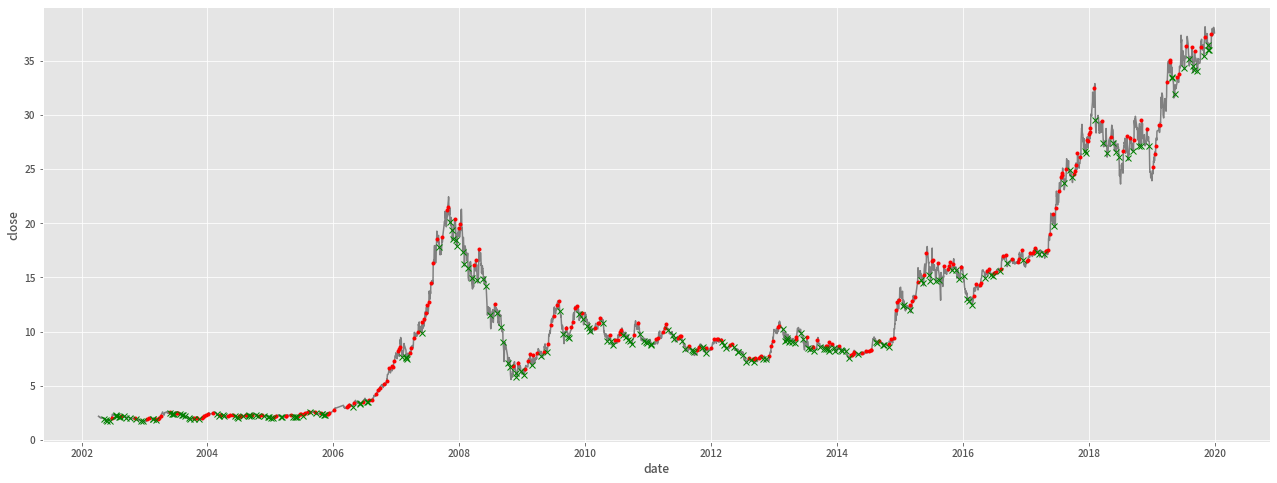

In [30]:
day=14
data=read_data('600036')
s=Simulation(data,'',callbacks=[CCI(day),
                Signal_CCI(day)])
s.simulate()
print(s.data['{}_未来可能'.format(day)].value_counts())
cci_1=s.data[(s.data['{}_未来可能'.format(day)]=='进入强势状态-5')]['date']
cci_2=s.data[(s.data['{}_未来可能'.format(day)]=='进入超卖区-3')]['date']
plot(s.data,'date',['close'],list(cci_1.values),list(cci_2.values))

### 600858

常态-0        3523
            1652
进入强势状态-5     347
进入超卖区-3      338
Name: 14_未来可能, dtype: int64


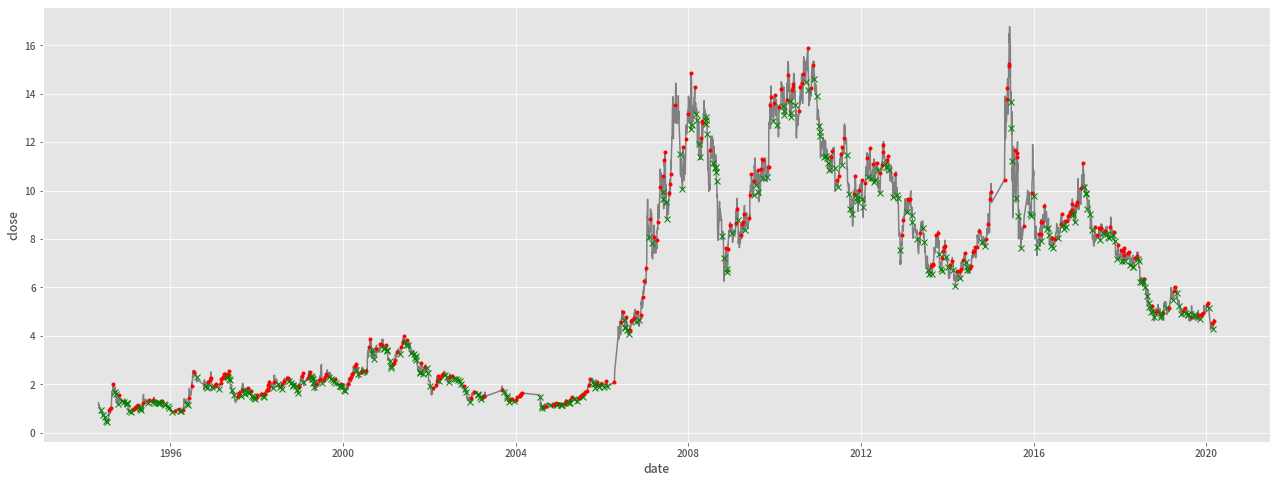

In [31]:
day=14
data=read_data('600858')
s=Simulation(data,'',callbacks=[CCI(day),
                Signal_CCI(day)])
s.simulate()
print(s.data['{}_未来可能'.format(day)].value_counts())
cci_1=s.data[(s.data['{}_未来可能'.format(day)]=='进入强势状态-5')]['date']
cci_2=s.data[(s.data['{}_未来可能'.format(day)]=='进入超卖区-3')]['date']
plot(s.data,'date',['close'],list(cci_1.values),list(cci_2.values))